# Online Retail Analysis with Pyspark

## Evaluation Assignment Statement

You are given a dataset with several transactions spanning from 2010 to 2011, across multiple countries and several invoices and products.

What we want you to do is to create a python program that is able to import this dataset inside a MongoDB. Then, you need to set up and use Apache Spark (https://docs.mongodb.com/spark-connector/current/) in order to manipulate the data.

What we need is:

• Group all transactions by invoice

• Which product sold the most?

• Which customer spent the most money?

• Give as a chart showing the distribution of each product for each of the available countries (for this you can answer by providing a view or a new collection, you can provide the chart with a graphic outside the code).

• What is the average unit price?

• Give us a chart showing the distribution of prices.

• Give us the ratio between price and quantity for each invoice.

All these answers can be provided either by creating a view for each or an API route. Make sure that your code is documented, clean and tested (we expect at least unit tests with a coverage of over 80%).

You can use docker and ready-made docker images.

You need to push your code in a public repository (github, bitbucket etc). 

## Uploading the dataset inside a MongoDB

In [1]:
def mongodbdata(file_path, sheet_name, host_path, db_name, collection_name):
    """
    - mongodbdata function loads data from xlsx file  
    - It creates and returns the data as a pandas dataframe
    - It creates a database inside mongodb 
    - It injects the data as collection inside the database
    """
    
    # Checking if the file extension is '.xlsx'
    if not file_path.endswith('.xlsx'):
        raise TypeError('the file format or extension is not valid xlsx')
    # Read an Excel file into a pandas DataFrame
    df = pd.read_excel(io=file_path, sheet_name=sheet_name)
    
    # Connect to MongoDB
    client = MongoClient(host_path)
    # Create database db_name
    db = client[db_name]
    # drop collection collection_name if exists 
    db[collection_name].drop()
    # Create collection collection_name
    collection = db[collection_name]
    # Insert collection
    collection.insert_many(df.to_dict("records"))
    # Checking if The collection was successfully created
    try:
        client[db_name].validate_collection(collection_name)  # Try to validate a collection
        print(f"The collection {collection_name} is successfully created")
    except pymongo.errors.OperationFailure:  # If the collection doesn't exist
        print(f"The collection {collection_name} is not yet created")
        
    return df

In [2]:
# Importing useful functions and libraries
import pandas as pd
from pymongo import MongoClient

# Path where the Excel file is stored\File
file_path = "data/Online Retail.xlsx"
# Name of the sheet
sheet_name = "Online Retail"
# hostname or IP address
#host_path = "mongodb://localhost:27017/"
host_path = "mongodb://mongo:27017/"
# Mongo database name 
db_name = "online_retail" 
# Name of the collection
collection_name = "retail"

# Load the dataframe for pandas and creating a database 
df = mongodbdata(file_path, sheet_name, host_path, db_name, collection_name)

The collection retail is successfully created


Let's show the first 5 rows of the pandas dataframe (not the dsitributed dataframe):

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Set up and using Apache Spark to manipulate the data

### Set up PySpark data loading

In [4]:
#Instantiation and create a SparkSession. No need to create SparkContext
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession

# The entry point into all functionality in Spark is the SparkSession class. 
# Create a SparkSession using SparkSession.builder:
# Specify the spark.mongodb.input.uri and spark.mongodb.output.uri configuration options to connect to mongodb databases

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Online Retail Analysis with Pyspark") \
    .config("spark.mongodb.input.uri", "mongodb://mongo:27017/online_retail.retail") \
    .config("spark.mongodb.output.uri", "mongodb://mongo:27017/online_retail.retail") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

In [6]:
import pyspark

def spark_shape(self):
    """
    spark_shape function returns the shape of a distributed collection of data grouped into named columns.
    """
    return (self.count(), len(self.columns))

# Adding spark_shape function to the native functions of spark
pyspark.sql.dataframe.DataFrame.shape = spark_shape

In [7]:
# Loading the distributed data from mongodb
dfs = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

# Showing the first 5 lines
dfs.show(5)

+--------------+----------+--------------------+-------------------+---------+--------+---------+---------+--------------------+
|       Country|CustomerID|         Description|        InvoiceDate|InvoiceNo|Quantity|StockCode|UnitPrice|                 _id|
+--------------+----------+--------------------+-------------------+---------+--------+---------+---------+--------------------+
|United Kingdom|   17850.0|WHITE HANGING HEA...|2010-12-01 09:26:00|   536365|       6|   85123A|     2.55|[61b8b66dbc5e8862...|
|United Kingdom|   17850.0| WHITE METAL LANTERN|2010-12-01 09:26:00|   536365|       6|    71053|     3.39|[61b8b66dbc5e8862...|
|United Kingdom|   17850.0|CREAM CUPID HEART...|2010-12-01 09:26:00|   536365|       8|   84406B|     2.75|[61b8b66dbc5e8862...|
|United Kingdom|   17850.0|KNITTED UNION FLA...|2010-12-01 09:26:00|   536365|       6|   84029G|     3.39|[61b8b66dbc5e8862...|
|United Kingdom|   17850.0|RED WOOLLY HOTTIE...|2010-12-01 09:26:00|   536365|       6|   84029E|

In [8]:
print("The distributed data shape:", dfs.shape())

The distributed data shape: (541909, 9)


### Data preprocessing

In [9]:
# Let's calculate some useful statistics
summary = dfs.describe().toPandas()
summary = summary.T
summary.columns = summary.iloc[0]
summary = summary.drop(summary.index[0])
summary

summary,count,mean,stddev,min,max
Country,541909,None,None,Australia,Unspecified
CustomerID,541909,NaN,NaN,12346.0,NaN
Description,541909,NaN,NaN,4 PURPLE FLOCK DINNER CANDLES,wrongly sold sets
InvoiceNo,541909,559965.752026781,13428.417280791635,536365,C581569
Quantity,541909,9.55224954743324,218.08115785023412,-80995,80995
StockCode,541909,27623.240210938104,16799.73762842766,10002,m
UnitPrice,541909,4.611113626084807,96.75985306117953,-11062.06,38970.0


The table column count suggests that there are missing values in Description and CustomerID columns. 

In [10]:
from pyspark.sql import functions as F

# Let's display the number of those missing values 
dfs.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in dfs.columns if c not in ["InvoiceDate", "_id"]]).show()

+-------+----------+-----------+---------+--------+---------+---------+
|Country|CustomerID|Description|InvoiceNo|Quantity|StockCode|UnitPrice|
+-------+----------+-----------+---------+--------+---------+---------+
|      0|    135080|       1454|        0|       0|        0|        0|
+-------+----------+-----------+---------+--------+---------+---------+



In [11]:
# Removing those missing values and checking if there are still missing values
dfs = dfs.dropna(subset=["Description", "CustomerID"])
dfs.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in dfs.columns if c not in ["InvoiceDate", "_id"]]).show()

+-------+----------+-----------+---------+--------+---------+---------+
|Country|CustomerID|Description|InvoiceNo|Quantity|StockCode|UnitPrice|
+-------+----------+-----------+---------+--------+---------+---------+
|      0|         0|          0|        0|       0|        0|        0|
+-------+----------+-----------+---------+--------+---------+---------+



In [12]:
# Print out the schema in the tree format of the distributed data collection
dfs.printSchema()

root
 |-- Country: string (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Description: string (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



The customerID column type is double. It is recommended to change its type to Integer because it is an ID.

In [13]:
# Convert double to Integer Type
dfs = dfs.withColumn("CustomerID", dfs.CustomerID.cast('int'))
dfs.printSchema()

root
 |-- Country: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [14]:
dfs.show(4)

+--------------+----------+--------------------+-------------------+---------+--------+---------+---------+--------------------+
|       Country|CustomerID|         Description|        InvoiceDate|InvoiceNo|Quantity|StockCode|UnitPrice|                 _id|
+--------------+----------+--------------------+-------------------+---------+--------+---------+---------+--------------------+
|United Kingdom|     17850|WHITE HANGING HEA...|2010-12-01 09:26:00|   536365|       6|   85123A|     2.55|[61b8b66dbc5e8862...|
|United Kingdom|     17850| WHITE METAL LANTERN|2010-12-01 09:26:00|   536365|       6|    71053|     3.39|[61b8b66dbc5e8862...|
|United Kingdom|     17850|CREAM CUPID HEART...|2010-12-01 09:26:00|   536365|       8|   84406B|     2.75|[61b8b66dbc5e8862...|
|United Kingdom|     17850|KNITTED UNION FLA...|2010-12-01 09:26:00|   536365|       6|   84029G|     3.39|[61b8b66dbc5e8862...|
+--------------+----------+--------------------+-------------------+---------+--------+---------+

The InvoiceNo transactions seem not all starting with letter "5". Removing all transactions that start with a letter different from "5" in the InvoiceNo column. 

In [15]:
# Counting the distinct beginning letters of the InvoiceNo column
dfs.withColumn("InvoiceNo_first_char", dfs.InvoiceNo.substr(1,1)).groupBy(["InvoiceNo_first_char"]).count().show()

+--------------------+------+
|InvoiceNo_first_char| count|
+--------------------+------+
|                   5|397924|
|                   C|  8905|
+--------------------+------+



In [16]:
# Removing all rows having the first letter different from 5 into the InvoiceNo column
dfs = dfs.filter(dfs.InvoiceNo.substr(1,1) == "5")
dfs.shape()

(397924, 9)

In [17]:
# Checking by counting the distinct beginning letters of the InvoiceNo column
dfs.withColumn("InvoiceNo_first_char", dfs.InvoiceNo.substr(1,1)).groupBy(["InvoiceNo_first_char"]).count().show()

+--------------------+------+
|InvoiceNo_first_char| count|
+--------------------+------+
|                   5|397924|
+--------------------+------+



It appears that the Country column contains an incorrect name for Ireland. We will have to correct it.

In [18]:
# Check if exists Ireland country name
dfs.filter(dfs.Country == "Ireland").show(5)
# Replace all EIRE country name by Ireland country name
dfs = dfs.replace(['EIRE'],['Ireland'])
dfs.show(5)

+-------+----------+-----------+-----------+---------+--------+---------+---------+---+
|Country|CustomerID|Description|InvoiceDate|InvoiceNo|Quantity|StockCode|UnitPrice|_id|
+-------+----------+-----------+-----------+---------+--------+---------+---------+---+
+-------+----------+-----------+-----------+---------+--------+---------+---------+---+

+--------------+----------+--------------------+-------------------+---------+--------+---------+---------+--------------------+
|       Country|CustomerID|         Description|        InvoiceDate|InvoiceNo|Quantity|StockCode|UnitPrice|                 _id|
+--------------+----------+--------------------+-------------------+---------+--------+---------+---------+--------------------+
|United Kingdom|     17850|WHITE HANGING HEA...|2010-12-01 09:26:00|   536365|       6|   85123A|     2.55|[61b8b66dbc5e8862...|
|United Kingdom|     17850| WHITE METAL LANTERN|2010-12-01 09:26:00|   536365|       6|    71053|     3.39|[61b8b66dbc5e8862...|
|U

Spark supports SQL - Structured Query Language - which traditionally has an important role in managing relational databases. The use of SQL queries offers a lot of flexibility for data analyses. Let us experiment with some very useful SQL queries, such as select and filter. We first need to register the DataFrame as a temporary table in the SQLContext.

In [19]:
# Register the distributed dataframe as a temporary table in the SQLContext
dfs.registerTempTable("dfs")

In [20]:
spark.sql("select Description, Quantity from dfs").show(7)

+--------------------+--------+
|         Description|Quantity|
+--------------------+--------+
|WHITE HANGING HEA...|       6|
| WHITE METAL LANTERN|       6|
|CREAM CUPID HEART...|       8|
|KNITTED UNION FLA...|       6|
|RED WOOLLY HOTTIE...|       6|
|SET 7 BABUSHKA NE...|       2|
|GLASS STAR FROSTE...|       6|
+--------------------+--------+
only showing top 7 rows



### Group all transactions by invoice

To count the number of transactions for each invoice, I propose two equivalent solutions:

In [21]:
sol1 = dfs.groupBy(["InvoiceNo"]).agg(F.sum("Quantity"))
sol1.show(7)

+---------+-------------+
|InvoiceNo|sum(Quantity)|
+---------+-------------+
|   536938|          464|
|   537691|          163|
|   538184|          314|
|   538517|          161|
|   538879|          402|
|   539275|          156|
|   539630|          244|
+---------+-------------+
only showing top 7 rows



In [22]:
sol2 = dfs["InvoiceNo", "Quantity"].groupBy('InvoiceNo').sum()
sol2.show(7)

+---------+-------------+
|InvoiceNo|sum(Quantity)|
+---------+-------------+
|   536938|          464|
|   537691|          163|
|   538184|          314|
|   538517|          161|
|   538879|          402|
|   539275|          156|
|   539630|          244|
+---------+-------------+
only showing top 7 rows



### Which product sold the most?

In order to see which product is selling the most, it is necessary to determine how many times each existing product in the Description column is called. To do this, select only the "Description" and "Quantity" columns and grouping by "Description" while aggregating by sum. Finally, do descending sort of the obtained dataframe.

In [23]:
solded_products = dfs["Description", "Quantity"].groupBy('Description').sum().orderBy(F.col("sum(Quantity)").desc())

solded_products.show(7)

+--------------------+-------------+
|         Description|sum(Quantity)|
+--------------------+-------------+
|PAPER CRAFT , LIT...|        80995|
|MEDIUM CERAMIC TO...|        77916|
|WORLD WAR 2 GLIDE...|        54415|
|JUMBO BAG RED RET...|        46181|
|WHITE HANGING HEA...|        36725|
|ASSORTED COLOUR B...|        35362|
|PACK OF 72 RETROS...|        33693|
+--------------------+-------------+
only showing top 7 rows



In [24]:
print(f"The best-selling product is {solded_products.first()[0]} with {solded_products.first()[1]} quantities.")

The best-selling product is PAPER CRAFT , LITTLE BIRDIE with 80995 quantities.


### Which customer spent the most money?

Following the same principle as the previous question, here I'll add new column "Spent" that represent the total expenses for each row by multiply the Quantity with the UnitPrice. I keep only two columns: "CustomerID" and "Spent" and grouping by CustomerID while aggregating by sum. Finally, do descending sort of the obtained dataframe. It is recommended to round the obtained values.

In [25]:
customers_spent = dfs.withColumn("Spent", F.col("Quantity") * F.col("UnitPrice"))["CustomerID", "Spent"]
customers_spent.show(4)

+----------+------------------+
|CustomerID|             Spent|
+----------+------------------+
|     17850|15.299999999999999|
|     17850|             20.34|
|     17850|              22.0|
|     17850|             20.34|
+----------+------------------+
only showing top 4 rows



In [26]:
most_customers_spent = customers_spent.groupBy(["CustomerID"]).agg(F.sum("Spent")).orderBy(F.col("sum(Spent)").desc())
most_customers_spent = most_customers_spent.withColumn("sum(Spent)", F.round(most_customers_spent["sum(Spent)"], 2))   
most_customers_spent.show(5)

+----------+----------+
|CustomerID|sum(Spent)|
+----------+----------+
|     14646| 280206.02|
|     18102|  259657.3|
|     17450| 194550.79|
|     16446|  168472.5|
|     14911| 143825.06|
+----------+----------+
only showing top 5 rows



In [27]:
print(f"Customer spending the most money is CutomerID number {most_customers_spent.first()[0]} with money spent of {most_customers_spent.first()[1]}")

Customer spending the most money is CutomerID number 14646 with money spent of 280206.02


### Chart showing the distribution of each product for each of the available countries

To give the distribution of each product for each of the available countries, it is required to calculate how much the expenses in each row by multiplying the Quantity with the UnitPrice. A new column called "Exp" will be added. Selecting only the "Country" and "Exp" columns and grouping by "Country" while aggregating over the sum produces a new dataframe that gives the total expenses for each country.

In [28]:
expc = dfs.withColumn("Exp", F.col("Quantity") * F.col("UnitPrice"))["Country", "Exp"].groupBy('Country').sum()
expc = expc.withColumn("sum(Exp)", F.round(expc["sum(Exp)"], 2))  
expc.orderBy(F.col("sum(Exp)").desc()).show(7)

+--------------+----------+
|       Country|  sum(Exp)|
+--------------+----------+
|United Kingdom|7308391.55|
|   Netherlands| 285446.34|
|       Ireland|  265545.9|
|       Germany| 228867.14|
|        France| 209024.05|
|     Australia| 138521.31|
|         Spain|  61577.11|
+--------------+----------+
only showing top 7 rows



I will convert the above distributed dataframe to a pandas dataframe by adding a new column "iso_alpha" mentioning the ISO Alpha-3 code for each country. Some corrections will be made to some country names.

In [29]:
country_exp = expc.toPandas()
country_exp.loc[country_exp["Country"] == "RSA", "Country"] = "South Africa"
country_exp.loc[country_exp["Country"] == "USA", "Country"] = "United States"
country_exp.loc[country_exp["Country"] == "Channel Islands", "Country"] = "United Kingdom"
country_exp = country_exp.groupby(['Country']).sum()

In [30]:
import pycountry

countries_codes = {}
for country in pycountry.countries:
    countries_codes[country.name] = country.alpha_3

country_exp['iso_alpha'] = [countries_codes.get(country, 'Unknown code') for country in country_exp.index]
country_exp.head(4)

,sum(Exp),iso_alpha
Country,,
Australia,138521.31,AUS
Austria,10198.68,AUT
Bahrain,548.40,BHR
Belgium,41196.34,BEL


I'll use plotly.express as well as plotly.graph_objectsuse to build two equivalent charts that will disply the distribution of each product for each of the available countries.

In [31]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot

fig = px.choropleth(country_exp, locations="iso_alpha",
                    color="sum(Exp)", 
                    hover_name=country_exp.index, # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
iplot(fig)

In [32]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations = country_exp['iso_alpha'],
    z = country_exp['sum(Exp)'],
    text = country_exp.index,
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Exp',
))
fig.update_layout(
    title_text='Country Exp',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)
iplot(fig)

### Average unit price

As for the previous question, to compute the average unit price, it is required to calculate how much the expenses in each row by multiplying the Quantity with the UnitPrice. A new column called "Exp" will be added. Selecting only the "Quantity" and "Exp" columns while aggregating over the sum gives a new dataframe with the total expenses and the total quantity (sum(Exp) and sum(Quantity) repectively). The average is the division of sum(Exp) by sum(Quantity).

In [33]:
expq = dfs.withColumn("Exp", F.col("Quantity") * F.col("UnitPrice"))["Quantity", "Exp"]
expq.show(5)

+--------+------------------+
|Quantity|               Exp|
+--------+------------------+
|       6|15.299999999999999|
|       6|             20.34|
|       8|              22.0|
|       6|             20.34|
|       6|             20.34|
+--------+------------------+
only showing top 5 rows



In [34]:
average = expq.groupBy().sum().withColumn("Average UnitPrice", F.col("sum(Exp)")/F.col("sum(Quantity)"))
average = average.withColumn("sum(Exp)", F.round(average["sum(Exp)"], 2)) 
average = average.withColumn("Average UnitPrice", F.round(average["Average UnitPrice"], 2))  
average.show()

+-------------+---------+-----------------+
|sum(Quantity)| sum(Exp)|Average UnitPrice|
+-------------+---------+-----------------+
|      5181696|8911407.9|             1.72|
+-------------+---------+-----------------+



In [35]:
print(f"The average unit price is {average.collect()[0]['Average UnitPrice']}")

The average unit price is 1.72


### Chart showing the distribution of prices

To show the distribution of prices, it is necessary to extract the month and year from the InvoiceDate column. Then, calculate total expenses according to each month as well as to each year. The resulting distributed dataframe will be converted into a pandas dataframe in order to use it to plot the chart using the Seaborn library.

In [36]:
price_dist = dfs.withColumn("Exp", F.col("Quantity") * F.col("UnitPrice"))
price_dist = price_dist.withColumn('Month', F.month(F.col('InvoiceDate')))
price_dist = price_dist.withColumn('Year', F.year(F.col('InvoiceDate')))['Year', "Month", "Exp"]

price_dist = price_dist.groupBy(["Month", "Year"]).agg(F.sum("Exp")).orderBy(F.col("Month"))
price_dist = price_dist.withColumn("sum(Exp)", F.round(price_dist["sum(Exp)"], 2))
price_dist.show(5)

+-----+----+---------+
|Month|Year| sum(Exp)|
+-----+----+---------+
|    1|2011|569445.04|
|    2|2011|447137.35|
|    3|2011|595500.76|
|    4|2011|469200.36|
|    5|2011|678594.56|
+-----+----+---------+
only showing top 5 rows



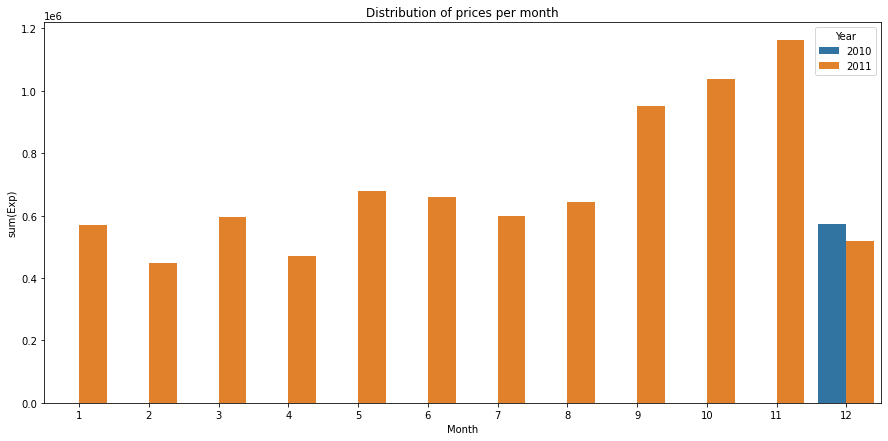

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

pdf = price_dist.toPandas()

plt.figure(figsize=[15,7])
g = sns.barplot(x='Month', y='sum(Exp)', hue='Year', data=pdf)
g.set_title('Distribution of prices per month');

### Ratio between price and quantity for each invoice

To compute the Ratio between price and quantity for each invoice, it is required to calculate how much the expenses in each row by multiplying the Quantity with the UnitPrice into new column called "Exp". A grouping by the InvoiceNo column while aggregating over the sum gives a new dataframe with the total expenses and the total quantity (sum(Exp) and sum(Quantity) repectively). By keeping only the 'InvoiceNo', 'sum(Quantity)' and "sum(Exp)" columns, the ratio for each InvoiceNo is obtained by dividing for each row the "sum(Exp)" value by the "sum(Quantity)" value.

In [38]:
ratio = dfs.withColumn("Exp", F.col("Quantity") * F.col("UnitPrice"))['InvoiceNo', 'Quantity', "Exp"]
ratio = ratio.groupBy(["InvoiceNo"]).sum()['InvoiceNo', 'sum(Quantity)', "sum(Exp)"]
ratio = ratio.withColumn("Ratio", F.col("sum(Exp)")/F.col("sum(Quantity)"))['InvoiceNo', "Ratio"]
ratio = ratio.withColumn("Ratio", F.round(ratio["Ratio"], 2))
ratio.show(7)

+---------+-----+
|InvoiceNo|Ratio|
+---------+-----+
|   536938| 3.62|
|   537691| 1.91|
|   538184| 1.46|
|   538517| 1.99|
|   538879| 0.84|
|   539275| 2.59|
|   539630| 3.08|
+---------+-----+
only showing top 7 rows

